In [1]:
#Talent Scouting-Klassifizierung mit Maschinellem Lernen

#Basierend auf den Bewertungen der Eigenschaften von Fußballspielern durch Scouts soll vorhergesagt werden,
#zu welcher Klasse (average, highlighted) die Spieler gehören.
    
#scoutium_attributes.csv
#task_response_id: Die Menge der Bewertungen eines Scouts zu allen Spielern eines Teams in einem Spiel
#match_id: ID des jeweiligen Spiels
#evaluator_id: ID des Bewerters (Scouts)
#player_id: ID des jeweiligen Spielers
#position_id: ID der Position, die der Spieler in diesem Spiel gespielt hat
#1: Torwart
#2: Innenverteidiger
#3: Rechtsverteidiger
#4: Linksverteidiger
#5: Defensives Mittelfeld
#6: Zentrales Mittelfeld
#7: Rechtsaußen
#8: Linksaußen
#9: Offensives Mittelfeld
#10: Stürmer
#analysis_id: Eine Menge von Eigenschaftsbewertungen eines Scouts zu einem Spieler in einem Spiel
#attribute_id: ID jeder einzelnen Eigenschaft, die bei den Spielern bewertet wurde
#attribute_value: Der Wert (Punktzahl), den ein Scout einer Eigenschaft eines Spielers gegeben hat

#scoutium_potential_labels.csv
#task_response_id: Die Menge der Bewertungen eines Scouts zu allen Spielern eines Teams in einem Spiel
#match_id: ID des jeweiligen Spiels
#evaluator_id: ID des Bewerters (Scouts)
#player_id: ID des jeweiligen Spielers
#potential_label: Das endgültige Urteil eines Scouts zu einem Spieler in einem Spiel (Zielvariable)


#Der Datensatz besteht aus Informationen über Fußballspieler, die bei Spielen von Scouts beobachtet wurden.
#Er enthält die von Scouts vergebenen Bewertungen zu spielbezogenen Eigenschaften der Spieler sowie deren Punktzahlen.


In [2]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#!pip install catboost
#!pip install lightgbm
#!pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# Train/test split ve metrikler için gerekli importlar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modeller için gerekli importlar
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier  # İstersen açabilirsin

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

import warnings
warnings.filterwarnings("ignore") 


In [3]:
df_attributes = pd.read_csv("C:/Users/nesri/repos/Scouting-Klassifizierung/scoutium_attributes.csv", sep=';')
df_potential_labels = pd.read_csv("C:/Users/nesri/repos/Scouting-Klassifizierung/scoutium_potential_labels.csv", sep=';')


In [4]:
df_attributes.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [5]:
df_potential_labels.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [6]:
df= pd.merge( df_attributes, df_potential_labels, on=["task_response_id", "match_id", "evaluator_id", "player_id"], how="outer")


In [7]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [8]:
df.isnull().sum()


task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
potential_label     0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 754.6+ KB


In [10]:
# Zeilen mit position_id == 1 (Torwart) entfernen
df= df[df["position_id"] != 1]

In [11]:
# Zeilen mit potential_label == "below_average" entfernen
# Diese Klasse macht nur ca. 1% des gesamten Datensatzes aus, daher beeinträchtigt das Entfernen nicht die Modellleistung
df = df[df["potential_label"] != "below_average"]

In [12]:
# Pivot-Tabelle erstellen
# Jede Zeile entspricht einem Spieler
df_pivot = df.pivot_table(
    index=["task_response_id", "match_id", "evaluator_id", "player_id", "position_id", "potential_label"],  # Spieler eindeutig identifizieren
    columns="attribute_id",  # Jede Spieler-Eigenschaft wird zu einer Spalte
    values="attribute_value",  # Die Bewertungen der Eigenschaften
).reset_index()
# Pivot-Tabelle-Spalten in Strings umwandeln
df_pivot.columns = df_pivot.columns.astype(str)

In [13]:
df_pivot

attribute_id,task_response_id,match_id,evaluator_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,4915,62935,177676,1361061,2,average,56.0,56.0,67.0,56.0,45.0,56.0,56.0,67.0,45.0,56.0,67.0,67.0,45.0,67.0,34.0,34.0,45.0,34.0,34.0,45.0,56.0,45.0,56.0,56.0,56.0,56.0,56.0,56.0,67.0,56.0,56.0,67.0,34.0,45.0
1,4915,62935,177676,1361626,10,highlighted,56.0,67.0,78.0,78.0,56.0,56.0,78.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,100.0,78.0,56.0,56.0,78.0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,78.0,56.0,78.0,67.0
2,4915,62935,177676,1361858,6,average,45.0,56.0,56.0,56.0,56.0,45.0,56.0,56.0,56.0,56.0,56.0,45.0,56.0,56.0,45.0,45.0,56.0,45.0,45.0,56.0,45.0,45.0,45.0,56.0,56.0,45.0,56.0,56.0,56.0,56.0,56.0,56.0,45.0,56.0
3,4915,62935,177676,1362220,5,highlighted,67.0,56.0,56.0,78.0,78.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,56.0,56.0,78.0,67.0,56.0,78.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0
4,4915,62935,177676,1364951,9,highlighted,45.0,56.0,56.0,78.0,78.0,56.0,56.0,45.0,56.0,56.0,56.0,34.0,67.0,45.0,56.0,56.0,67.0,56.0,45.0,56.0,45.0,56.0,67.0,56.0,67.0,67.0,67.0,67.0,45.0,45.0,67.0,45.0,56.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,5642,63032,151191,1367778,5,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,78.0,67.0,78.0
286,5642,63032,151191,1367783,2,highlighted,78.0,78.0,67.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,78.0,67.0,78.0,78.0,67.0,67.0,78.0,56.0,56.0,67.0,78.0,56.0,67.0,78.0,67.0,78.0,78.0,78.0,67.0,67.0,67.0,78.0,67.0,78.0
287,5642,63032,151191,1369525,2,average,67.0,78.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,67.0,78.0
288,5642,63032,151191,1369546,10,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0


In [14]:
# LabelEncoder erstellen
le = LabelEncoder()
# 'potential_label' Spalte in numerische Werte umwandeln
df_pivot["potential_label_encoded"] = le.fit_transform(df_pivot["potential_label"])


In [15]:
# Alle numerischen Spalten auswählen, außer 'potential_label_encoded'
num_cols = df_pivot.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Ziel- und ID-Spalten entfernen, nur Features behalten
num_cols = [col for col in num_cols if col not in ["potential_label_encoded", 
                                                   "task_response_id", 
                                                   "match_id", 
                                                   "evaluator_id", 
                                                   "player_id", 
                                                   "position_id"]]


In [16]:
# StandardScaler-Objekt erstellen
scaler = StandardScaler()

# Numerische Spalten skalieren und wieder ins DataFrame schreiben
df_pivot[num_cols] = scaler.fit_transform(df_pivot[num_cols])

# Kontrolle: die ersten paar Zeilen anzeigen
df_pivot[num_cols].head()


attribute_id,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-0.182193,-0.211373,0.661238,-0.080475,-0.784862,-0.052914,-0.165229,0.393418,-0.869437,-0.150911,0.443979,0.995064,-0.787859,0.822521,-1.285069,-1.455402,-0.928727,-0.749128,-0.569610,-0.667626,0.240833,-0.025846,0.056083,-0.072787,-0.013617,0.103900,-0.211996,-0.139002,0.897073,-0.002629,-0.160360,0.651961,-0.963546,-0.930245
1,-0.182193,0.545395,1.351018,1.425186,-0.036145,-0.052914,1.355928,0.393418,1.509211,0.674830,0.443979,0.995064,0.618166,0.081741,0.167835,0.793621,0.580130,1.219879,3.347868,1.436846,0.240833,0.655557,1.605042,0.708998,0.776175,1.505336,1.042675,0.621576,0.897073,0.759714,1.207413,-0.058824,1.762585,0.372997
2,-0.947929,-0.211373,-0.028543,-0.080475,-0.036145,-0.820175,-0.165229,-0.210239,-0.076554,-0.150911,-0.233673,-0.366108,-0.084846,0.081741,-0.558617,-0.705728,-0.174299,-0.092792,0.083303,0.033865,-0.388370,-0.025846,-0.718397,-0.072787,-0.013617,-0.596819,-0.211996,-0.139002,0.180403,-0.002629,-0.160360,-0.058824,-0.282014,-0.278624
3,0.583544,-0.211373,-0.028543,1.425186,1.461289,1.481606,0.595350,0.393418,0.716328,0.674830,0.443979,0.995064,0.618166,0.822521,0.894288,0.043946,0.580130,1.219879,0.736216,0.033865,0.240833,2.018363,0.830563,-0.072787,1.565967,0.804618,1.042675,0.621576,0.897073,0.759714,0.523527,-0.058824,1.081052,0.372997
4,-0.947929,-0.211373,-0.028543,1.425186,1.461289,-0.052914,-0.165229,-0.813897,-0.076554,-0.150911,-0.233673,-1.046695,0.618166,-0.659039,0.167835,0.043946,0.580130,0.563543,0.083303,0.033865,-0.388370,0.655557,0.830563,-0.072787,0.776175,0.804618,0.415339,0.621576,-0.536267,-0.764971,0.523527,-0.769608,0.399519,-0.278624


In [17]:
X = df_pivot[num_cols]
y = df_pivot["potential_label_encoded"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Modellliste
classifiers = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("SVC", SVC(probability=True)),
    ("CART", DecisionTreeClassifier()),
    ("RF", RandomForestClassifier()),
    ('Adaboost', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
]


# Modelle trainieren und Metriken berechnen
for name, model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Für ROC-AUC brauchen wir Wahrscheinlichkeiten
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
    
    print(f"--- {name} ---")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall   :", round(recall_score(y_test, y_pred), 4))
    print("F1 Score :", round(f1_score(y_test, y_pred), 4))
    print("ROC-AUC  :", round(roc_auc_score(y_test, y_proba), 4))
    print("\n")


--- LR ---
Accuracy : 0.8621
Precision: 0.7
Recall   : 0.5833
F1 Score : 0.6364
ROC-AUC  : 0.7337


--- KNN ---
Accuracy : 0.7931
Precision: 0.5
Recall   : 0.0833
F1 Score : 0.1429
ROC-AUC  : 0.7455


--- SVC ---
Accuracy : 0.8276
Precision: 1.0
Recall   : 0.1667
F1 Score : 0.2857
ROC-AUC  : 0.8496


--- CART ---
Accuracy : 0.8448
Precision: 0.6364
Recall   : 0.5833
F1 Score : 0.6087
ROC-AUC  : 0.7482


--- RF ---
Accuracy : 0.8621
Precision: 1.0
Recall   : 0.3333
F1 Score : 0.5
ROC-AUC  : 0.846


--- Adaboost ---
Accuracy : 0.8793
Precision: 1.0
Recall   : 0.4167
F1 Score : 0.5882
ROC-AUC  : 0.7609


--- GBM ---
Accuracy : 0.8621
Precision: 0.8333
Recall   : 0.4167
F1 Score : 0.5556
ROC-AUC  : 0.8261


--- XGBoost ---
Accuracy : 0.8621
Precision: 0.8333
Recall   : 0.4167
F1 Score : 0.5556
ROC-AUC  : 0.7717




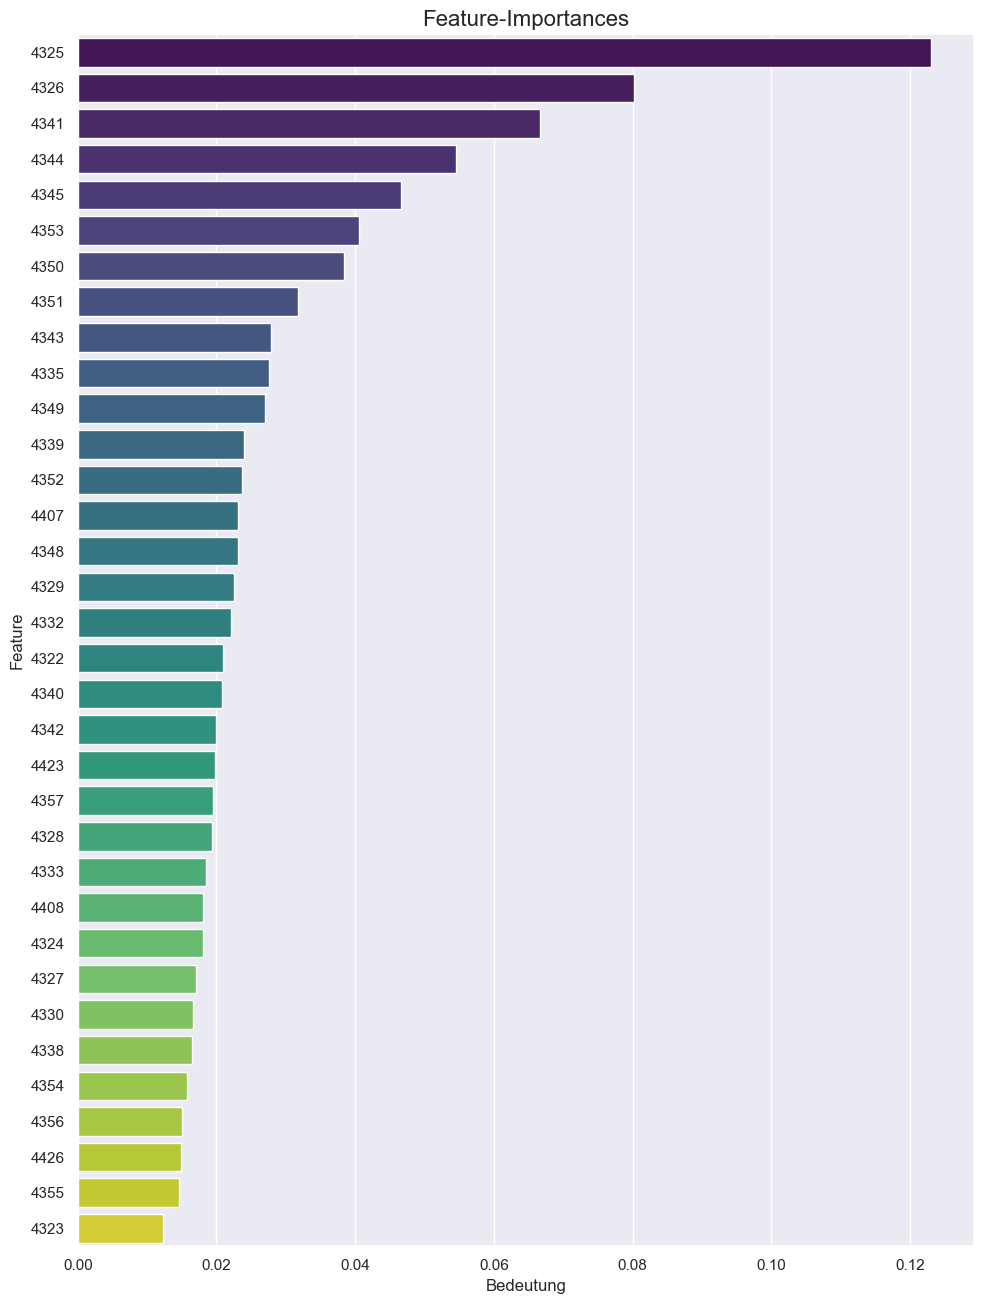

In [18]:
#Erstellen mit der Funktion feature_importance eine Grafik, die die Rangfolge der Merkmale nach ihrer Wichtigkeit darstellt.

def plot_importance(model, features, num=None, save=False):
  
    if num is None:
        num = features.shape[1]
    
    feature_imp = pd.DataFrame({
        "Wert": model.feature_importances_,
        "Feature": features.columns
    })
    
    # Plot
    plt.figure(figsize=(10, num*0.3 + 3))
    sns.set(font_scale=1)
    
    # Farbige Balken
    sns.barplot(
        x="Wert", 
        y="Feature", 
        data=feature_imp.sort_values(by="Wert", ascending=False).head(num),
        palette="viridis"  # Beliebige Farbpalette möglich: 'coolwarm', 'Set2', etc.
    )
    
    plt.title("Feature-Importances", fontsize=16)
    plt.xlabel("Bedeutung", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    
    if save:
        plt.savefig("feature_importances.png", dpi=300)
    
    plt.show()

# Beispiel: RandomForest verwenden
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

plot_importance(model, X)
